In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(21664, 28)
(21664, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, 24] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.63652642e-02,
       -1.83961355e-03,  2.59306532e-03,  2.54300085e-04,  6.98410068e-04,
        1.33650489e-03,  2.37189174e-01,  1.00829604e-01, -4.09156909e-01,
        2.32088141e-01, -1.37870899e-01, -4.09158935e-01, -2.48274169e-01,
        1.40812067e-01, -4.09153397e-01, -2.44928543e-01, -9.62744031e-02,
       -4.09155152e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_RR_swinging[0, :]

array([-0.00828009,  0.04045801, -0.00636973, -0.04229659])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 3:9],
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9965071888794352
RMSE:  0.005081389045505169
The lowest error is:  3.5146707601449445e-06
The highest error is:  0.09184288994008555
The avg. error is:  0.003045195613910854


In [11]:
model_rr_relative_swinging_x.coef_

array([[ 0.06344051, -0.00716245,  0.00201564,  0.21204235,  0.01966099,
         0.01090911,  0.02709588,  0.0213779 ,  0.00310731,  0.00835518,
         0.07521112,  0.07586045, -0.00420039,  0.19430828, -0.01179764,
        -0.05298584,  0.01149527, -0.04887089, -0.00773726,  0.16839448]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([-0.00897636])

Text(0, 0.5, 'Predictions')

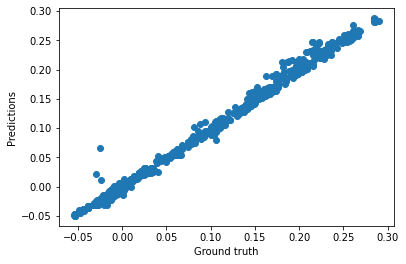

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 3:9],
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9933749113037869
RMSE:  0.006276020069537154
The lowest error is:  3.0136093961659685e-07
The highest error is:  0.1187767089971312
The avg. error is:  0.0032423611300983284


In [21]:
model_rr_relative_swinging_y.coef_

array([[-0.0155568 ,  0.0643704 , -0.03810496,  0.02307837,  0.22379678,
        -0.02321892,  0.03002271,  0.02417401, -0.00313337, -0.01086804,
        -0.10451044, -0.00223342,  0.01722882, -0.10173892, -0.09181096,
        -0.06068971, -0.05344539, -0.03952463,  0.01821698, -0.13989253]])

In [19]:
model_rr_relative_swinging_y.intercept_

array([-0.00233286])

Text(0, 0.5, 'Predictions')

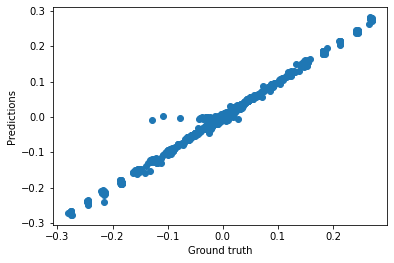

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")